# Kaggle - Help to Protect the Great Barrier Reef

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Make sure to run COTS_download.ipynb ahead or download dataset to your drive and change the relative paths**

## Environment Preparation

### Install Libraries

In [15]:
! pip install wandb -qqq
! pip install -qU bbox-utility # check https://github.com/awsaf49/bbox for source code

### Import Libraries

In [16]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import shutil
import sys

from joblib import Parallel, delayed

from IPython.display import display


In [17]:
# Use Weights & Biases (W&B) MLOps platform for tracking the experiments
# Log in to your W&B account

import wandb
wandb.login()

wandb: Currently logged in as: erisedtang (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Metadata Setting

In [18]:
FOLD      = 1 # which fold to train
DIM       = 3000 
MODEL     = 'yolov5s6'
BATCH     = 4
EPOCHS    = 10
OPTMIZER  = 'Adam'

PROJECT   = 'great-barrier-reef-test' # w&b in yolov5
NAME      = f'{MODEL}-dim{DIM}-fold{FOLD}-epoch{EPOCHS}' # w&b for yolov5

REMOVE_NOBBOX = True # remove images with no bbox
ROOT_DIR  = '/content/drive/MyDrive/Protect_Reef' # directory to save original data
IMAGE_DIR = '/content/drive/MyDrive/Protect_Reef_Process/images' # directory to save images
LABEL_DIR = '/content/drive/MyDrive/Protect_Reef_Process/labels' # directory to save labels

## Create Directory

In [ ]:
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

## Get Path

In [19]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df['old_image_path'] = f'{ROOT_DIR}/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['image_path']  = f'{IMAGE_DIR}/'+df.image_id+'.jpg'
df['label_path']  = f'{LABEL_DIR}/'+df.image_id+'.txt'
df['annotations'] = df['annotations'].progress_apply(eval)
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path
0,0,40258,0,0,0-0,[],/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...
1,0,40258,1,1,0-1,[],/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...


## Check the Number of BBOX

In [20]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


## Clean Data

In [21]:
# Only train the model using data with annotations (bbox)
if REMOVE_NOBBOX:
    df = df.query("num_bbox>0")

## Write Images

In [ ]:
def make_copy(row):
    shutil.copyfile(row.old_image_path, row.image_path)
    return

In [ ]:
image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(row) for _, row in tqdm(df.iterrows(), total=len(df)))

## Helper Function

In [22]:
# check https://github.com/awsaf49/bbox for source code of following utility functions
from bbox.utils import coco2yolo, coco2voc, voc2yolo
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

## Create BBox

In [23]:
df['bboxes'] = df.annotations.progress_apply(get_bbox)
df.head(2)

  0%|          | 0/4919 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path,num_bbox,bboxes
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...,1,"[[559, 213, 50, 32]]"
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...,1,"[[558, 213, 50, 32]]"


## Get Image Size
All images have same dimension [1280, 720].

In [24]:
df['width']  = 1280
df['height'] = 720
display(df.head(2))

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path,num_bbox,bboxes,width,height
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...,1,"[[559, 213, 50, 32]]",1280,720
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/content/drive/MyDrive/Protect_Reef/train_imag...,/content/drive/MyDrive/Protect_Reef_Process/im...,/content/drive/MyDrive/Protect_Reef_Process/la...,1,"[[558, 213, 50, 32]]",1280,720


## Create Lables

In [ ]:
# Change annotations to yolo format
cnt = 0
all_bboxes = []
bboxes_info = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width  = row.width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = np.array([0]*num_bbox)[..., None].astype(str)
    ## Create Annotation(YOLO)
    with open(row.label_path, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
            cnt+=1
            continue
        bboxes_voc  = coco2voc(bboxes_coco, image_height, image_width)
        bboxes_voc  = clip_bbox(bboxes_voc, image_height, image_width)
        bboxes_yolo = voc2yolo(bboxes_voc, image_height, image_width).astype(str)
        all_bboxes.extend(bboxes_yolo.astype(float))
        bboxes_info.extend([[row.image_id, row.video_id, row.sequence]]*len(bboxes_yolo))
        annots = np.concatenate([labels, bboxes_yolo], axis=1)
        string = annot2str(annots)
        f.write(string)
print('Missing:',cnt)

  0%|          | 0/4919 [00:00<?, ?it/s]

Missing: 0


## Create Folds
K-fold iterator variant with non-overlapping groups.
The same group will not appear in two different folds (the number of distinct groups has to be at least equal to the number of folds).
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

In [25]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 3)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df, groups=df.video_id.tolist())):
    df.loc[val_idx, 'fold'] = fold
display(df.fold.value_counts())

0    2143
1    2099
2     677
Name: fold, dtype: int64

## BBOX Distribution

In [26]:
bbox_df = pd.DataFrame(np.concatenate([bboxes_info, all_bboxes], axis=1),
             columns=['image_id','video_id','sequence',
                     'xmid','ymid','w','h'])
bbox_df[['xmid','ymid','w','h']] = bbox_df[['xmid','ymid','w','h']].astype(float)
bbox_df['area'] = bbox_df.w * bbox_df.h * 1280 * 720
bbox_df = bbox_df.merge(df[['image_id','fold']], on='image_id', how='left')
bbox_df.head(2)

,image_id,video_id,sequence,xmid,ymid,w,h,area,fold
0,0-16,0,40258,0.456250,0.318056,0.039062,0.044444,1600.00092,0
1,0-17,0,40258,0.455469,0.318056,0.039062,0.044444,1600.00092,0


### X Center V.S. Y Center

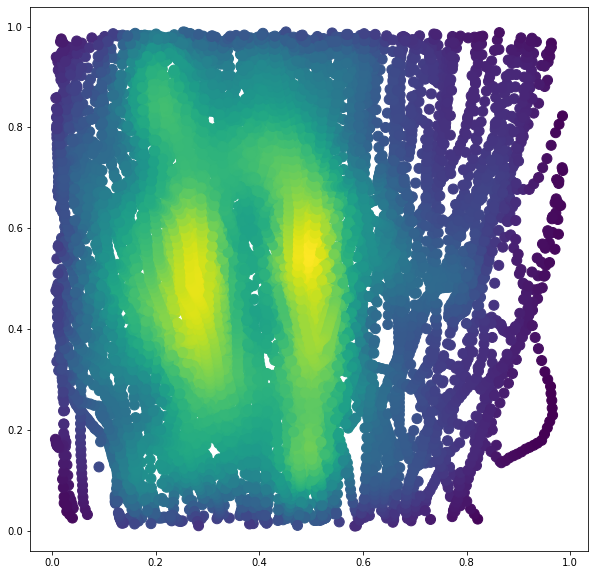

In [27]:
from scipy.stats import gaussian_kde

all_bboxes = np.array(all_bboxes)

x_val = all_bboxes[...,0]
y_val = all_bboxes[...,1]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('x_mid')
# ax.set_ylabel('y_mid')
plt.show()

### Width V.S. Height

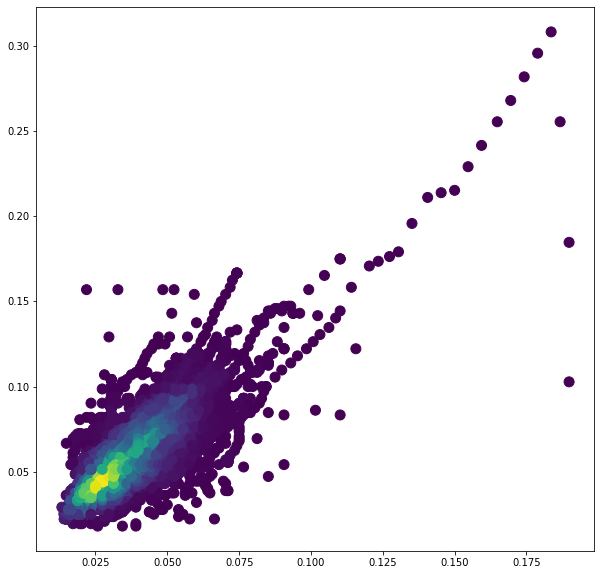

In [28]:
x_val = all_bboxes[...,2]
y_val = all_bboxes[...,3]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('bbox_width')
# ax.set_ylabel('bbox_height')
plt.show()

### Area

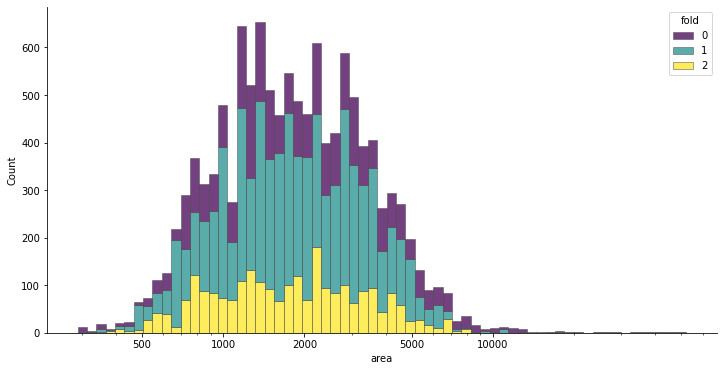

In [29]:
import matplotlib as mpl
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 6))
sns.despine(f)

sns.histplot(
    bbox_df,
    x="area", hue="fold",
    multiple="stack",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([500, 1000, 2000, 5000, 10000]);

## Data Visulization

In [30]:
df2 = df[(df.num_bbox>0)].sample(100) # takes samples with bbox
y = 3; x = 2
plt.figure(figsize=(12.8*x, 7.2*y))
for idx in range(x*y):
    row = df2.iloc[idx]
    img           = load_image(row.image_path)
    image_height  = row.height
    image_width   = row.width
    with open(row.label_path) as f:
        annot = str2annot(f.read())
    bboxes_yolo = annot[...,1:]
    labels      = annot[..., 0].astype(int).tolist()
    names         = ['cots']*len(bboxes_yolo)
    plt.subplot(y, x, idx+1)
    plt.imshow(draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2))
    plt.axis('OFF')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.